In [62]:
# Import libraries
import pandas as pd
import glob 
import numpy as np
import matplotlib.pyplot as plt
import os
import skgstat as skg
from skgstat import models
import gstatsim as gs
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import QuantileTransformer 
import pyproj # for reprojection

In [63]:
# Fields paths
field_a_paths = glob.glob("D:/Cours bioingé/BIR M2/Mémoire/Data/Drone GPR/Field A/*.txt") # return all file paths that match a specific pattern
field_b_paths = glob.glob("D:/Cours bioingé/BIR M2/Mémoire/Data/Drone GPR/Field B/*.txt")

In [64]:
sample_number = 0           # [0-10]
field_path = field_a_paths  # field_a_paths or field_b_paths

In [65]:
# Define the transformer for WGS84 to UTM (UTM zone 32N)
transformer = pyproj.Transformer.from_crs("epsg:4326", "epsg:32632", always_xy=True)

In [66]:
# Import data function
gpr_data_tables = []
def import_data(file_paths=glob.glob("D:/Cours bioingé/BIR M2/Mémoire/Data/Drone GPR/Field A/*.txt")):
    gpr_data_tables = []
    for file_path in file_paths:
        data_frame = pd.read_csv(file_path, sep = "  ", engine="python") # read csv file
        data_frame.columns = ['y', 'x', 'vwc'] # rename columns
        gpr_data_tables.append(data_frame)

    return gpr_data_tables

# Extract dates function
dates = []
def extract_dates(file_paths=glob.glob("D:/Cours bioingé/BIR M2/Mémoire/Data/Drone GPR/Field A/*.txt")):
    for file_path in file_paths:
        file_name = os.path.basename(file_path)
        file_name_without_extension = os.path.splitext(file_name)[0]
        date = file_name_without_extension[4:6] + "/" + file_name_without_extension[2:4] + "/" + "20" + file_name_without_extension[:2]
        dates.append(date)
        
    return dates

In [67]:
# Letter of the field
if field_path == field_a_paths:
    field_letter = "A"
else:
    field_letter = "B"

# Date of the files
extract_dates(field_path)

['16/05/2023',
 '04/07/2023',
 '19/07/2023',
 '07/08/2023',
 '06/09/2023',
 '18/09/2023',
 '04/10/2023',
 '16/10/2023',
 '06/11/2023',
 '05/02/2024',
 '13/03/2024']

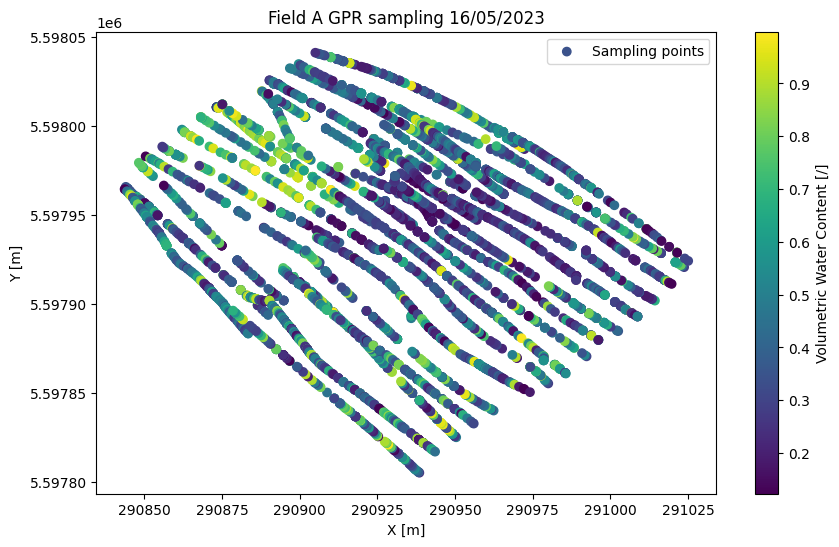

In [68]:
# Read csv file
Studied_field = import_data(field_path)[sample_number]

# Convert latitude and longitude to UTM coordinates
utm_x, utm_y = transformer.transform(Studied_field['x'].values, Studied_field['y'].values)

# Plot the sampling points
plt.figure(figsize=(10, 6))
scatter = plt.scatter(utm_x, utm_y, c=Studied_field['vwc'], cmap='viridis', label='Sampling points')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title(f'Field {field_letter} GPR sampling {dates[sample_number]}')
cb = plt.colorbar(scatter)
cb.set_label('Volumetric Water Content [/]')
plt.grid(False)
plt.legend()
plt.show()

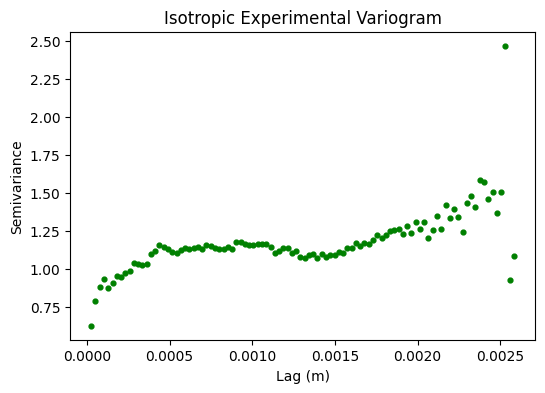

In [69]:
# grid data to ? m resolution
res = 0.00002  
df_grid, grid_matrix, rows, cols = gs.Gridding.grid_data(Studied_field, 'x', 'y', 'vwc', res)

# remove nans
df_grid = df_grid[df_grid['Z'].isnull() == False]

# normal score transformation
data = df_grid['Z'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution='normal').fit(data)
df_grid['Nbed'] = nst_trans.transform(data) 

# compute experimental (isotropic) variogram
coords = df_grid[['X','Y']].values
values = df_grid['Nbed']

maxlag = 10      # maximum range distance
n_lags = 100         # num of bins

# compute variogram
V1 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, maxlag=maxlag, normalize=False)

# extract variogram values
xdata = V1.bins
ydata = V1.experimental

plt.figure(figsize=(6,4))
plt.scatter(xdata, ydata, s=12, c='g')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.show()

In [70]:
# use exponential variogram model
V1.model = 'exponential' 
V1.parameters

[0.00025329036101605964, 1.2046181674901943, 0]

In [71]:
# use Gaussian model
V2 = V1
V2.model = 'gaussian' 
V2.parameters

[9.228593063779899e-05, 1.1853496532322723, 0]

In [72]:
# use spherical model
V3 = V1
V3.model = 'spherical' 
V3.parameters

[0.0001260789391834781, 1.18853667157741, 0]

The range describes the correlation length, or distance where two measurements are no longer correlated. The sill is variance where the range is reached. The nugget is the variance at a lag distance of zero.

In [73]:
# evaluate models
xi =np.linspace(0, xdata[-1], 100) 

y_exp = [models.exponential(h, V1.parameters[0], V1.parameters[1], V1.parameters[2]) for h in xi]
y_gauss = [models.gaussian(h, V2.parameters[0], V2.parameters[1], V2.parameters[2]) for h in xi]
y_sph = [models.spherical(h, V3.parameters[0], V3.parameters[1], V3.parameters[2]) for h in xi]

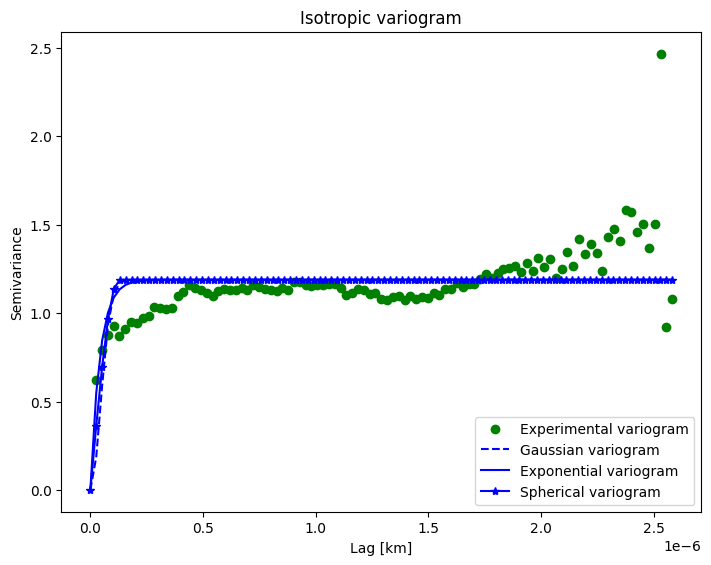

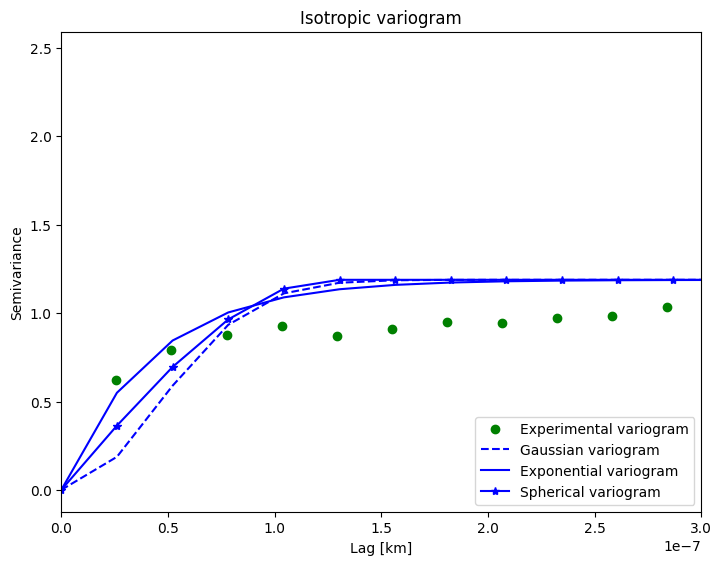

In [ ]:
# plot variogram model
fig = plt.figure()
plt.plot(xdata/1000,ydata,'og', label = "Experimental variogram")
plt.plot(xi/1000, y_gauss,'b--', label='Gaussian variogram')
plt.plot(xi/1000, y_exp,'b-', label='Exponential variogram')
plt.plot(xi/1000, y_sph,'b*-', label='Spherical variogram')
plt.title('Isotropic variogram')
plt.xlabel('Lag [km]'); plt.ylabel('Semivariance')  
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1.0) # adjust the plot size
plt.legend(loc='lower right')

fig = plt.figure()
plt.plot(xdata/1000,ydata,'og', label = "Experimental variogram")
plt.plot(xi/1000, y_gauss,'b--', label='Gaussian variogram')
plt.plot(xi/1000, y_exp,'b-', label='Exponential variogram')
plt.plot(xi/1000, y_sph,'b*-', label='Spherical variogram')
plt.title('Isotropic variogram')
plt.xlim(0,0.0000003)
plt.xlabel('Lag [km]'); plt.ylabel('Semivariance')  
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1.0) # adjust the plot size
plt.legend(loc='lower right')